In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns
import os
import scipy
import scipy.io

In [2]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [3]:
a = scipy.io.loadmat("../data/zeisel/zeisel_data.mat")
data= a['zeisel_data'].T
N,d=data.shape

#load labels (first level of the hierarchy) from file
a = scipy.io.loadmat("../data/zeisel/zeisel_labels1.mat")
l_aux = a['zeisel_labels1']
l_0=[l_aux[i][0] for i in range(l_aux.shape[0])]
#load labels (second level of the hierarchy) from file
a = scipy.io.loadmat("../data/zeisel/zeisel_labels2.mat")
l_aux = a['zeisel_labels2']
l_1=[l_aux[i][0] for i in range(l_aux.shape[0])]
#construct an array with hierarchy labels
labels=np.array([l_0, l_1])

# load names from file 
a = scipy.io.loadmat("../data/zeisel/zeisel_names.mat")
names0=np.array([a['zeisel_names'][i][0][0] for i in range(N)])
names1=[a['zeisel_names'][i][1][0] for i in range(N)]

np.random.seed(100)
slices = np.random.permutation(np.arange(data.shape[0]))
upto = int(.8 * len(data))

train_data = data[slices[:upto]]
test_data = data[slices[upto:]]

train_labels = names0[slices[:upto]]
test_labels = names0[slices[upto:]]


scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

train_data = Tensor(train_data).to(device)
test_data = Tensor(test_data).to(device)

In [4]:
N = 10000
z_size = 100

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.000005
b1 = 0.9
b2 = 0.999

global_t = 4
k = 50

In [5]:
def train_model(train_data, model):
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=lr, 
                                 betas = (b1,b2))
        
    for epoch in range(1, n_epochs+1):
        train(train_data, 
              model, 
              optimizer, 
              epoch, 
              batch_size)
        model.t = max(0.001, model.t * 0.99)

        
    return model

def save_model(base_path, model):
    # make directory
    if not os.path.exists(os.path.dirname(base_path)):
        try:
            os.makedirs(os.path.dirname(base_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise Exception("COULD NOT MAKE PATH")
    with open(base_path, 'wb') as PATH:
        torch.save(model.state_dict(), PATH)
        
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, a = 0.01)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [6]:
def top_logits_gumbel_globalgate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_GlobalGate)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = data.shape[1]).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

def top_logits_gumbel_runningstate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_RunningState)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = data.shape[1]).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

def top_logits_gumbel_concrete_vae_nsml(data, model):
    assert isinstance(model, ConcreteVAE_NMSL)
    
    with torch.no_grad():

        w = gumbel_keys(model.logit_enc, EPSILON = torch.finfo(torch.float32).eps)
        w = torch.softmax(w/model.t, dim = -1)
        subset_indices = w.clone().detach()

        #max_idx = torch.argmax(subset_indices, 1, keepdim=True)
        #one_hot = Tensor(subset_indices.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        all_subsets = subset_indices.sum(dim = 0)

        inds = torch.argsort(subset_indices.sum(dim = 0), descending = True)[:model.k]
        all_logits = torch.nn.functional.one_hot(inds, num_classes = data.shape[1]).sum(dim = 0)
        
        
        
        
    return all_logits, all_subsets

In [7]:
model = VAE_Gumbel_RunningState(train_data.shape[1], 200, 50, k = k, t = global_t, alpha = 0.9, bias = False)


In [8]:
model

VAE_Gumbel_RunningState(
  (encoder): Sequential(
    (0): Linear(in_features=4000, out_features=200, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=200, out_features=50, bias=False)
  (enc_logvar): Linear(in_features=200, out_features=50, bias=False)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=4000, bias=False)
    (3): Sigmoid()
  )
  (weight_creator): Sequential(
    (0): Linear(in_features=4000, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=4000, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)

In [9]:
model.to(device)
model.apply(weights_init)
train_model(train_data, model)
model.set_burned_in()

Train Epoch: 1 [0/2404 (0%)]	Loss: 3548.767822
Train Epoch: 1 [1280/2404 (53%)]	Loss: 3558.993896
====> Epoch: 1 Average loss: 3585.3947
Train Epoch: 2 [0/2404 (0%)]	Loss: 3593.806396
Train Epoch: 2 [1280/2404 (53%)]	Loss: 3547.668701
====> Epoch: 2 Average loss: 3559.4802
Train Epoch: 3 [0/2404 (0%)]	Loss: 3550.117188
Train Epoch: 3 [1280/2404 (53%)]	Loss: 3545.724854
====> Epoch: 3 Average loss: 3542.6768
Train Epoch: 4 [0/2404 (0%)]	Loss: 3533.979004
Train Epoch: 4 [1280/2404 (53%)]	Loss: 3569.495605
====> Epoch: 4 Average loss: 3519.2883
Train Epoch: 5 [0/2404 (0%)]	Loss: 3456.928223
Train Epoch: 5 [1280/2404 (53%)]	Loss: 3539.192383
====> Epoch: 5 Average loss: 3496.2448
Train Epoch: 6 [0/2404 (0%)]	Loss: 3443.856689
Train Epoch: 6 [1280/2404 (53%)]	Loss: 3444.872559
====> Epoch: 6 Average loss: 3474.2354
Train Epoch: 7 [0/2404 (0%)]	Loss: 3430.343506
Train Epoch: 7 [1280/2404 (53%)]	Loss: 3487.277344
====> Epoch: 7 Average loss: 3446.5636
Train Epoch: 8 [0/2404 (0%)]	Loss: 3465.0

====> Epoch: 59 Average loss: 2609.9625
Train Epoch: 60 [0/2404 (0%)]	Loss: 2580.540283
Train Epoch: 60 [1280/2404 (53%)]	Loss: 2604.245605
====> Epoch: 60 Average loss: 2602.4067
Train Epoch: 61 [0/2404 (0%)]	Loss: 2589.575684
Train Epoch: 61 [1280/2404 (53%)]	Loss: 2602.631592
====> Epoch: 61 Average loss: 2596.1407
Train Epoch: 62 [0/2404 (0%)]	Loss: 2631.609131
Train Epoch: 62 [1280/2404 (53%)]	Loss: 2589.927734
====> Epoch: 62 Average loss: 2589.1494
Train Epoch: 63 [0/2404 (0%)]	Loss: 2605.089600
Train Epoch: 63 [1280/2404 (53%)]	Loss: 2591.831787
====> Epoch: 63 Average loss: 2582.9163
Train Epoch: 64 [0/2404 (0%)]	Loss: 2582.053711
Train Epoch: 64 [1280/2404 (53%)]	Loss: 2594.992188
====> Epoch: 64 Average loss: 2576.2056
Train Epoch: 65 [0/2404 (0%)]	Loss: 2563.031494
Train Epoch: 65 [1280/2404 (53%)]	Loss: 2558.393555
====> Epoch: 65 Average loss: 2569.1610
Train Epoch: 66 [0/2404 (0%)]	Loss: 2582.192627
Train Epoch: 66 [1280/2404 (53%)]	Loss: 2583.887451
====> Epoch: 66 Aver

Train Epoch: 118 [1280/2404 (53%)]	Loss: 2308.852539
====> Epoch: 118 Average loss: 2303.6641
Train Epoch: 119 [0/2404 (0%)]	Loss: 2300.818604
Train Epoch: 119 [1280/2404 (53%)]	Loss: 2346.068848
====> Epoch: 119 Average loss: 2299.9107
Train Epoch: 120 [0/2404 (0%)]	Loss: 2235.799316
Train Epoch: 120 [1280/2404 (53%)]	Loss: 2192.942871
====> Epoch: 120 Average loss: 2297.3206
Train Epoch: 121 [0/2404 (0%)]	Loss: 2371.008057
Train Epoch: 121 [1280/2404 (53%)]	Loss: 2214.359131
====> Epoch: 121 Average loss: 2299.9213
Train Epoch: 122 [0/2404 (0%)]	Loss: 2305.806396
Train Epoch: 122 [1280/2404 (53%)]	Loss: 2336.720703
====> Epoch: 122 Average loss: 2292.3534
Train Epoch: 123 [0/2404 (0%)]	Loss: 2300.647949
Train Epoch: 123 [1280/2404 (53%)]	Loss: 2319.701172
====> Epoch: 123 Average loss: 2289.6904
Train Epoch: 124 [0/2404 (0%)]	Loss: 2251.471191
Train Epoch: 124 [1280/2404 (53%)]	Loss: 2255.997070
====> Epoch: 124 Average loss: 2288.5318
Train Epoch: 125 [0/2404 (0%)]	Loss: 2283.795410

====> Epoch: 175 Average loss: 2195.8120
Train Epoch: 176 [0/2404 (0%)]	Loss: 2219.748535
Train Epoch: 176 [1280/2404 (53%)]	Loss: 2221.672119
====> Epoch: 176 Average loss: 2196.1051
Train Epoch: 177 [0/2404 (0%)]	Loss: 2181.943359
Train Epoch: 177 [1280/2404 (53%)]	Loss: 2214.969238
====> Epoch: 177 Average loss: 2193.3812
Train Epoch: 178 [0/2404 (0%)]	Loss: 2286.789062
Train Epoch: 178 [1280/2404 (53%)]	Loss: 2206.752930
====> Epoch: 178 Average loss: 2194.1345
Train Epoch: 179 [0/2404 (0%)]	Loss: 2199.141113
Train Epoch: 179 [1280/2404 (53%)]	Loss: 2168.801025
====> Epoch: 179 Average loss: 2191.7062
Train Epoch: 180 [0/2404 (0%)]	Loss: 2298.654541
Train Epoch: 180 [1280/2404 (53%)]	Loss: 2123.452881
====> Epoch: 180 Average loss: 2191.0110
Train Epoch: 181 [0/2404 (0%)]	Loss: 2154.438721
Train Epoch: 181 [1280/2404 (53%)]	Loss: 2236.853516
====> Epoch: 181 Average loss: 2187.3567
Train Epoch: 182 [0/2404 (0%)]	Loss: 2154.096191
Train Epoch: 182 [1280/2404 (53%)]	Loss: 2141.883789

Train Epoch: 233 [1280/2404 (53%)]	Loss: 2205.952148
====> Epoch: 233 Average loss: 2133.0277
Train Epoch: 234 [0/2404 (0%)]	Loss: 2098.094971
Train Epoch: 234 [1280/2404 (53%)]	Loss: 2216.880371
====> Epoch: 234 Average loss: 2128.7162
Train Epoch: 235 [0/2404 (0%)]	Loss: 2181.151123
Train Epoch: 235 [1280/2404 (53%)]	Loss: 2083.884033
====> Epoch: 235 Average loss: 2128.5516
Train Epoch: 236 [0/2404 (0%)]	Loss: 2126.237305
Train Epoch: 236 [1280/2404 (53%)]	Loss: 2146.350098
====> Epoch: 236 Average loss: 2124.4113
Train Epoch: 237 [0/2404 (0%)]	Loss: 2154.992920
Train Epoch: 237 [1280/2404 (53%)]	Loss: 2151.401611
====> Epoch: 237 Average loss: 2122.0359
Train Epoch: 238 [0/2404 (0%)]	Loss: 2070.885742
Train Epoch: 238 [1280/2404 (53%)]	Loss: 2194.197998
====> Epoch: 238 Average loss: 2120.2428
Train Epoch: 239 [0/2404 (0%)]	Loss: 2075.188477
Train Epoch: 239 [1280/2404 (53%)]	Loss: 2164.273926
====> Epoch: 239 Average loss: 2120.7936
Train Epoch: 240 [0/2404 (0%)]	Loss: 2138.024902

====> Epoch: 290 Average loss: 2076.8246
Train Epoch: 291 [0/2404 (0%)]	Loss: 2226.269287
Train Epoch: 291 [1280/2404 (53%)]	Loss: 2100.001465
====> Epoch: 291 Average loss: 2078.9439
Train Epoch: 292 [0/2404 (0%)]	Loss: 2154.890137
Train Epoch: 292 [1280/2404 (53%)]	Loss: 2172.308350
====> Epoch: 292 Average loss: 2076.5991
Train Epoch: 293 [0/2404 (0%)]	Loss: 2051.280518
Train Epoch: 293 [1280/2404 (53%)]	Loss: 2025.769165
====> Epoch: 293 Average loss: 2082.8090
Train Epoch: 294 [0/2404 (0%)]	Loss: 2006.175537
Train Epoch: 294 [1280/2404 (53%)]	Loss: 2080.706787
====> Epoch: 294 Average loss: 2084.5208
Train Epoch: 295 [0/2404 (0%)]	Loss: 2118.914551
Train Epoch: 295 [1280/2404 (53%)]	Loss: 1976.280396
====> Epoch: 295 Average loss: 2072.4054
Train Epoch: 296 [0/2404 (0%)]	Loss: 2100.788818
Train Epoch: 296 [1280/2404 (53%)]	Loss: 2044.175049
====> Epoch: 296 Average loss: 2070.1261
Train Epoch: 297 [0/2404 (0%)]	Loss: 2092.439209
Train Epoch: 297 [1280/2404 (53%)]	Loss: 2089.497559

Train Epoch: 348 [1280/2404 (53%)]	Loss: 2107.439941
====> Epoch: 348 Average loss: 2046.8346
Train Epoch: 349 [0/2404 (0%)]	Loss: 2083.104004
Train Epoch: 349 [1280/2404 (53%)]	Loss: 2133.912842
====> Epoch: 349 Average loss: 2046.3099
Train Epoch: 350 [0/2404 (0%)]	Loss: 1999.661987
Train Epoch: 350 [1280/2404 (53%)]	Loss: 2005.409058
====> Epoch: 350 Average loss: 2045.9791
Train Epoch: 351 [0/2404 (0%)]	Loss: 1963.534058
Train Epoch: 351 [1280/2404 (53%)]	Loss: 1974.246704
====> Epoch: 351 Average loss: 2044.5717
Train Epoch: 352 [0/2404 (0%)]	Loss: 2155.236328
Train Epoch: 352 [1280/2404 (53%)]	Loss: 2071.001221
====> Epoch: 352 Average loss: 2045.5262
Train Epoch: 353 [0/2404 (0%)]	Loss: 1978.857910
Train Epoch: 353 [1280/2404 (53%)]	Loss: 2026.000610
====> Epoch: 353 Average loss: 2045.2449
Train Epoch: 354 [0/2404 (0%)]	Loss: 2101.805664
Train Epoch: 354 [1280/2404 (53%)]	Loss: 1939.144287
====> Epoch: 354 Average loss: 2042.7937
Train Epoch: 355 [0/2404 (0%)]	Loss: 2010.194092

====> Epoch: 405 Average loss: 2017.1594
Train Epoch: 406 [0/2404 (0%)]	Loss: 1987.998779
Train Epoch: 406 [1280/2404 (53%)]	Loss: 1974.262695
====> Epoch: 406 Average loss: 2017.4129
Train Epoch: 407 [0/2404 (0%)]	Loss: 2039.366577
Train Epoch: 407 [1280/2404 (53%)]	Loss: 2056.781738
====> Epoch: 407 Average loss: 2017.3233
Train Epoch: 408 [0/2404 (0%)]	Loss: 2059.506348
Train Epoch: 408 [1280/2404 (53%)]	Loss: 1976.668823
====> Epoch: 408 Average loss: 2015.7990
Train Epoch: 409 [0/2404 (0%)]	Loss: 2148.167236
Train Epoch: 409 [1280/2404 (53%)]	Loss: 2202.415039
====> Epoch: 409 Average loss: 2015.7974
Train Epoch: 410 [0/2404 (0%)]	Loss: 1954.345581
Train Epoch: 410 [1280/2404 (53%)]	Loss: 2062.274902
====> Epoch: 410 Average loss: 2015.0059
Train Epoch: 411 [0/2404 (0%)]	Loss: 2053.715820
Train Epoch: 411 [1280/2404 (53%)]	Loss: 2057.484863
====> Epoch: 411 Average loss: 2014.0026
Train Epoch: 412 [0/2404 (0%)]	Loss: 1993.593994
Train Epoch: 412 [1280/2404 (53%)]	Loss: 2018.463501

Train Epoch: 463 [1280/2404 (53%)]	Loss: 2020.069336
====> Epoch: 463 Average loss: 1997.6203
Train Epoch: 464 [0/2404 (0%)]	Loss: 1822.114868
Train Epoch: 464 [1280/2404 (53%)]	Loss: 2066.474854
====> Epoch: 464 Average loss: 1997.9797
Train Epoch: 465 [0/2404 (0%)]	Loss: 1946.045532
Train Epoch: 465 [1280/2404 (53%)]	Loss: 1999.924927
====> Epoch: 465 Average loss: 1998.1409
Train Epoch: 466 [0/2404 (0%)]	Loss: 2032.333374
Train Epoch: 466 [1280/2404 (53%)]	Loss: 1994.748291
====> Epoch: 466 Average loss: 1995.5321
Train Epoch: 467 [0/2404 (0%)]	Loss: 2010.280884
Train Epoch: 467 [1280/2404 (53%)]	Loss: 2033.453735
====> Epoch: 467 Average loss: 1996.1685
Train Epoch: 468 [0/2404 (0%)]	Loss: 2013.058350
Train Epoch: 468 [1280/2404 (53%)]	Loss: 2096.145996
====> Epoch: 468 Average loss: 1996.6021
Train Epoch: 469 [0/2404 (0%)]	Loss: 2074.619873
Train Epoch: 469 [1280/2404 (53%)]	Loss: 1884.312256
====> Epoch: 469 Average loss: 1996.5592
Train Epoch: 470 [0/2404 (0%)]	Loss: 1934.012451

====> Epoch: 520 Average loss: 1981.4552
Train Epoch: 521 [0/2404 (0%)]	Loss: 2101.772949
Train Epoch: 521 [1280/2404 (53%)]	Loss: 1963.190430
====> Epoch: 521 Average loss: 1982.4671
Train Epoch: 522 [0/2404 (0%)]	Loss: 1983.232300
Train Epoch: 522 [1280/2404 (53%)]	Loss: 1953.987915
====> Epoch: 522 Average loss: 1981.6957
Train Epoch: 523 [0/2404 (0%)]	Loss: 2064.430176
Train Epoch: 523 [1280/2404 (53%)]	Loss: 1975.211914
====> Epoch: 523 Average loss: 1981.3248
Train Epoch: 524 [0/2404 (0%)]	Loss: 1971.892212
Train Epoch: 524 [1280/2404 (53%)]	Loss: 1969.849609
====> Epoch: 524 Average loss: 1981.2048
Train Epoch: 525 [0/2404 (0%)]	Loss: 1935.049316
Train Epoch: 525 [1280/2404 (53%)]	Loss: 2115.310059
====> Epoch: 525 Average loss: 1980.8663
Train Epoch: 526 [0/2404 (0%)]	Loss: 1923.137817
Train Epoch: 526 [1280/2404 (53%)]	Loss: 1924.238403
====> Epoch: 526 Average loss: 1980.2353
Train Epoch: 527 [0/2404 (0%)]	Loss: 1911.270508
Train Epoch: 527 [1280/2404 (53%)]	Loss: 1961.949341

Train Epoch: 578 [1280/2404 (53%)]	Loss: 1986.275024
====> Epoch: 578 Average loss: 1967.7716
Train Epoch: 579 [0/2404 (0%)]	Loss: 1990.701660
Train Epoch: 579 [1280/2404 (53%)]	Loss: 1880.657349
====> Epoch: 579 Average loss: 1968.3523
Train Epoch: 580 [0/2404 (0%)]	Loss: 2031.315308
Train Epoch: 580 [1280/2404 (53%)]	Loss: 2010.965576
====> Epoch: 580 Average loss: 1968.0612
Train Epoch: 581 [0/2404 (0%)]	Loss: 1991.519287
Train Epoch: 581 [1280/2404 (53%)]	Loss: 1930.268311
====> Epoch: 581 Average loss: 1967.2659
Train Epoch: 582 [0/2404 (0%)]	Loss: 1932.280762
Train Epoch: 582 [1280/2404 (53%)]	Loss: 1915.762695
====> Epoch: 582 Average loss: 1967.8572
Train Epoch: 583 [0/2404 (0%)]	Loss: 1950.092285
Train Epoch: 583 [1280/2404 (53%)]	Loss: 1982.859375
====> Epoch: 583 Average loss: 1968.0099
Train Epoch: 584 [0/2404 (0%)]	Loss: 2022.138550
Train Epoch: 584 [1280/2404 (53%)]	Loss: 1963.858643
====> Epoch: 584 Average loss: 1966.6220
Train Epoch: 585 [0/2404 (0%)]	Loss: 1934.415405

In [10]:
test_data

tensor([[0.5910, 0.2284, 0.3724,  ..., 0.0000, 0.0000, 0.0000],
        [0.6055, 0.4852, 0.5453,  ..., 0.0000, 0.3010, 0.2307],
        [0.8040, 0.7024, 0.7303,  ..., 0.3333, 0.3010, 0.0000],
        ...,
        [0.7733, 0.5431, 0.6092,  ..., 0.0000, 0.0000, 0.0000],
        [0.7283, 0.3427, 0.6368,  ..., 0.0000, 0.3010, 0.0000],
        [0.7518, 0.7861, 0.7848,  ..., 0.0000, 0.3010, 0.5542]],
       device='cuda:0')

In [11]:
model.eval()
model(test_data)[0]

tensor([[0.6460, 0.5640, 0.3666,  ..., 0.0400, 0.1213, 0.0356],
        [0.5739, 0.4607, 0.4719,  ..., 0.0835, 0.1081, 0.0455],
        [0.7381, 0.6720, 0.6451,  ..., 0.2977, 0.2557, 0.4677],
        ...,
        [0.7931, 0.4101, 0.5725,  ..., 0.0198, 0.0509, 0.0069],
        [0.6471, 0.5306, 0.4251,  ..., 0.1197, 0.2289, 0.0978],
        [0.7744, 0.6798, 0.7063,  ..., 0.2457, 0.1839, 0.2075]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [12]:
top_logits_running_state = top_logits_gumbel_runningstate_vae(test_data, model)

In [13]:
torch.argsort(top_logits_running_state[0], descending = True)[:k]

tensor([   2,    4,    8,   25,   26,   73,   77,   97,  134,  166,  170,  189,
         203,  220,  252,  290,  341,  356,  430,  431,  443,  547,  581,  621,
         715,  767,  798,  870,  898,  945, 1031, 1047, 1077, 1169, 1193, 1224,
        1268, 1275, 1392, 1412, 1751, 1798, 1925, 2276, 2341, 2625, 3011, 3073,
        3235, 3250], device='cuda:0')

In [14]:
inds_running_state = torch.argsort(top_logits_running_state[1], descending = True)[:50].cpu().numpy()

In [15]:
len(labels[0])
print("HOW TO GET NAME OF FEATURES?")

HOW TO GET NAME OF FEATURES?


In [16]:
#save_model("../data/models/final_run_zeisel/runningstate_vae/k_50/model.pt", model)

Train Global Gate too.

In [17]:
model = VAE_Gumbel_GlobalGate(train_data.shape[1], 200, 50, k = k, t = global_t, bias = False)
model.to(device)
model.apply(weights_init)
train_model(train_data, model)

Train Epoch: 1 [0/2404 (0%)]	Loss: 3624.992920
Train Epoch: 1 [1280/2404 (53%)]	Loss: 3613.580566
====> Epoch: 1 Average loss: 3599.0869
Train Epoch: 2 [0/2404 (0%)]	Loss: 3593.959961
Train Epoch: 2 [1280/2404 (53%)]	Loss: 3573.421143
====> Epoch: 2 Average loss: 3570.6041
Train Epoch: 3 [0/2404 (0%)]	Loss: 3537.198975
Train Epoch: 3 [1280/2404 (53%)]	Loss: 3545.182129
====> Epoch: 3 Average loss: 3547.2168
Train Epoch: 4 [0/2404 (0%)]	Loss: 3528.919434
Train Epoch: 4 [1280/2404 (53%)]	Loss: 3537.617188
====> Epoch: 4 Average loss: 3524.3150
Train Epoch: 5 [0/2404 (0%)]	Loss: 3529.102051
Train Epoch: 5 [1280/2404 (53%)]	Loss: 3509.404297
====> Epoch: 5 Average loss: 3495.8875
Train Epoch: 6 [0/2404 (0%)]	Loss: 3507.113525
Train Epoch: 6 [1280/2404 (53%)]	Loss: 3458.392822
====> Epoch: 6 Average loss: 3479.6583
Train Epoch: 7 [0/2404 (0%)]	Loss: 3468.275391
Train Epoch: 7 [1280/2404 (53%)]	Loss: 3446.258789
====> Epoch: 7 Average loss: 3456.7514
Train Epoch: 8 [0/2404 (0%)]	Loss: 3454.2

====> Epoch: 59 Average loss: 2698.6254
Train Epoch: 60 [0/2404 (0%)]	Loss: 2651.695557
Train Epoch: 60 [1280/2404 (53%)]	Loss: 2657.739746
====> Epoch: 60 Average loss: 2687.3705
Train Epoch: 61 [0/2404 (0%)]	Loss: 2678.493408
Train Epoch: 61 [1280/2404 (53%)]	Loss: 2686.138184
====> Epoch: 61 Average loss: 2679.5633
Train Epoch: 62 [0/2404 (0%)]	Loss: 2685.856689
Train Epoch: 62 [1280/2404 (53%)]	Loss: 2683.937256
====> Epoch: 62 Average loss: 2670.7639
Train Epoch: 63 [0/2404 (0%)]	Loss: 2723.837402
Train Epoch: 63 [1280/2404 (53%)]	Loss: 2671.708252
====> Epoch: 63 Average loss: 2663.8601
Train Epoch: 64 [0/2404 (0%)]	Loss: 2693.491211
Train Epoch: 64 [1280/2404 (53%)]	Loss: 2649.213867
====> Epoch: 64 Average loss: 2654.7489
Train Epoch: 65 [0/2404 (0%)]	Loss: 2672.531006
Train Epoch: 65 [1280/2404 (53%)]	Loss: 2632.656250
====> Epoch: 65 Average loss: 2648.0968
Train Epoch: 66 [0/2404 (0%)]	Loss: 2665.963623
Train Epoch: 66 [1280/2404 (53%)]	Loss: 2577.401367
====> Epoch: 66 Aver

Train Epoch: 118 [1280/2404 (53%)]	Loss: 2335.177246
====> Epoch: 118 Average loss: 2342.6710
Train Epoch: 119 [0/2404 (0%)]	Loss: 2363.330078
Train Epoch: 119 [1280/2404 (53%)]	Loss: 2451.282471
====> Epoch: 119 Average loss: 2341.6537
Train Epoch: 120 [0/2404 (0%)]	Loss: 2348.016113
Train Epoch: 120 [1280/2404 (53%)]	Loss: 2378.010742
====> Epoch: 120 Average loss: 2338.4609
Train Epoch: 121 [0/2404 (0%)]	Loss: 2339.276611
Train Epoch: 121 [1280/2404 (53%)]	Loss: 2353.199219
====> Epoch: 121 Average loss: 2333.2727
Train Epoch: 122 [0/2404 (0%)]	Loss: 2274.478516
Train Epoch: 122 [1280/2404 (53%)]	Loss: 2348.659180
====> Epoch: 122 Average loss: 2330.4968
Train Epoch: 123 [0/2404 (0%)]	Loss: 2352.647461
Train Epoch: 123 [1280/2404 (53%)]	Loss: 2367.715820
====> Epoch: 123 Average loss: 2328.4749
Train Epoch: 124 [0/2404 (0%)]	Loss: 2231.862549
Train Epoch: 124 [1280/2404 (53%)]	Loss: 2340.694580
====> Epoch: 124 Average loss: 2321.8945
Train Epoch: 125 [0/2404 (0%)]	Loss: 2345.550049

====> Epoch: 175 Average loss: 2174.9899
Train Epoch: 176 [0/2404 (0%)]	Loss: 2147.165283
Train Epoch: 176 [1280/2404 (53%)]	Loss: 2142.338623
====> Epoch: 176 Average loss: 2173.8383
Train Epoch: 177 [0/2404 (0%)]	Loss: 2097.419189
Train Epoch: 177 [1280/2404 (53%)]	Loss: 2097.596191
====> Epoch: 177 Average loss: 2170.9707
Train Epoch: 178 [0/2404 (0%)]	Loss: 2207.643799
Train Epoch: 178 [1280/2404 (53%)]	Loss: 2072.537842
====> Epoch: 178 Average loss: 2168.7564
Train Epoch: 179 [0/2404 (0%)]	Loss: 2087.782715
Train Epoch: 179 [1280/2404 (53%)]	Loss: 2350.078857
====> Epoch: 179 Average loss: 2166.4501
Train Epoch: 180 [0/2404 (0%)]	Loss: 2195.727783
Train Epoch: 180 [1280/2404 (53%)]	Loss: 2213.841064
====> Epoch: 180 Average loss: 2163.9228
Train Epoch: 181 [0/2404 (0%)]	Loss: 2123.007568
Train Epoch: 181 [1280/2404 (53%)]	Loss: 2169.388916
====> Epoch: 181 Average loss: 2162.7475
Train Epoch: 182 [0/2404 (0%)]	Loss: 2118.635254
Train Epoch: 182 [1280/2404 (53%)]	Loss: 2169.578613

Train Epoch: 233 [1280/2404 (53%)]	Loss: 2034.776733
====> Epoch: 233 Average loss: 2088.0510
Train Epoch: 234 [0/2404 (0%)]	Loss: 2050.258301
Train Epoch: 234 [1280/2404 (53%)]	Loss: 2003.623535
====> Epoch: 234 Average loss: 2087.4712
Train Epoch: 235 [0/2404 (0%)]	Loss: 2127.976318
Train Epoch: 235 [1280/2404 (53%)]	Loss: 2038.761230
====> Epoch: 235 Average loss: 2087.3741
Train Epoch: 236 [0/2404 (0%)]	Loss: 2125.019043
Train Epoch: 236 [1280/2404 (53%)]	Loss: 2136.464600
====> Epoch: 236 Average loss: 2084.5877
Train Epoch: 237 [0/2404 (0%)]	Loss: 2163.937744
Train Epoch: 237 [1280/2404 (53%)]	Loss: 2121.191406
====> Epoch: 237 Average loss: 2083.8463
Train Epoch: 238 [0/2404 (0%)]	Loss: 2019.928345
Train Epoch: 238 [1280/2404 (53%)]	Loss: 2008.324585
====> Epoch: 238 Average loss: 2082.3869
Train Epoch: 239 [0/2404 (0%)]	Loss: 1952.380981
Train Epoch: 239 [1280/2404 (53%)]	Loss: 2052.406250
====> Epoch: 239 Average loss: 2083.0331
Train Epoch: 240 [0/2404 (0%)]	Loss: 2074.769531

====> Epoch: 290 Average loss: 2046.7171
Train Epoch: 291 [0/2404 (0%)]	Loss: 2062.399902
Train Epoch: 291 [1280/2404 (53%)]	Loss: 2014.735352
====> Epoch: 291 Average loss: 2046.3309
Train Epoch: 292 [0/2404 (0%)]	Loss: 1939.845337
Train Epoch: 292 [1280/2404 (53%)]	Loss: 2209.389404
====> Epoch: 292 Average loss: 2045.5660
Train Epoch: 293 [0/2404 (0%)]	Loss: 1987.051270
Train Epoch: 293 [1280/2404 (53%)]	Loss: 2049.841064
====> Epoch: 293 Average loss: 2044.7539
Train Epoch: 294 [0/2404 (0%)]	Loss: 2079.937988
Train Epoch: 294 [1280/2404 (53%)]	Loss: 2112.408691
====> Epoch: 294 Average loss: 2044.1744
Train Epoch: 295 [0/2404 (0%)]	Loss: 1982.487793
Train Epoch: 295 [1280/2404 (53%)]	Loss: 1978.967285
====> Epoch: 295 Average loss: 2045.1408
Train Epoch: 296 [0/2404 (0%)]	Loss: 2099.854004
Train Epoch: 296 [1280/2404 (53%)]	Loss: 2068.159424
====> Epoch: 296 Average loss: 2044.6501
Train Epoch: 297 [0/2404 (0%)]	Loss: 2031.073120
Train Epoch: 297 [1280/2404 (53%)]	Loss: 2113.230225

Train Epoch: 348 [1280/2404 (53%)]	Loss: 1997.922974
====> Epoch: 348 Average loss: 2021.4700
Train Epoch: 349 [0/2404 (0%)]	Loss: 1890.808838
Train Epoch: 349 [1280/2404 (53%)]	Loss: 2046.195190
====> Epoch: 349 Average loss: 2021.5946
Train Epoch: 350 [0/2404 (0%)]	Loss: 2061.645752
Train Epoch: 350 [1280/2404 (53%)]	Loss: 1980.486572
====> Epoch: 350 Average loss: 2020.8879
Train Epoch: 351 [0/2404 (0%)]	Loss: 1961.124023
Train Epoch: 351 [1280/2404 (53%)]	Loss: 1997.402832
====> Epoch: 351 Average loss: 2020.4214
Train Epoch: 352 [0/2404 (0%)]	Loss: 2072.330566
Train Epoch: 352 [1280/2404 (53%)]	Loss: 2046.488159
====> Epoch: 352 Average loss: 2020.8380
Train Epoch: 353 [0/2404 (0%)]	Loss: 2057.821533
Train Epoch: 353 [1280/2404 (53%)]	Loss: 2091.953613
====> Epoch: 353 Average loss: 2019.9503
Train Epoch: 354 [0/2404 (0%)]	Loss: 2076.011719
Train Epoch: 354 [1280/2404 (53%)]	Loss: 1984.619019
====> Epoch: 354 Average loss: 2020.9947
Train Epoch: 355 [0/2404 (0%)]	Loss: 2087.264893

====> Epoch: 405 Average loss: 2006.0595
Train Epoch: 406 [0/2404 (0%)]	Loss: 2047.478882
Train Epoch: 406 [1280/2404 (53%)]	Loss: 1969.508667
====> Epoch: 406 Average loss: 2003.7728
Train Epoch: 407 [0/2404 (0%)]	Loss: 1954.724854
Train Epoch: 407 [1280/2404 (53%)]	Loss: 1990.236206
====> Epoch: 407 Average loss: 2003.9686
Train Epoch: 408 [0/2404 (0%)]	Loss: 1909.980225
Train Epoch: 408 [1280/2404 (53%)]	Loss: 1963.173584
====> Epoch: 408 Average loss: 2004.0278
Train Epoch: 409 [0/2404 (0%)]	Loss: 2068.431885
Train Epoch: 409 [1280/2404 (53%)]	Loss: 2091.500732
====> Epoch: 409 Average loss: 2003.3622
Train Epoch: 410 [0/2404 (0%)]	Loss: 2029.570679
Train Epoch: 410 [1280/2404 (53%)]	Loss: 1955.142334
====> Epoch: 410 Average loss: 2003.7534
Train Epoch: 411 [0/2404 (0%)]	Loss: 1955.052246
Train Epoch: 411 [1280/2404 (53%)]	Loss: 1997.230591
====> Epoch: 411 Average loss: 2003.9942
Train Epoch: 412 [0/2404 (0%)]	Loss: 2018.851318
Train Epoch: 412 [1280/2404 (53%)]	Loss: 1995.382690

Train Epoch: 463 [1280/2404 (53%)]	Loss: 1828.652954
====> Epoch: 463 Average loss: 1992.1513
Train Epoch: 464 [0/2404 (0%)]	Loss: 1959.845093
Train Epoch: 464 [1280/2404 (53%)]	Loss: 2077.463867
====> Epoch: 464 Average loss: 1990.6876
Train Epoch: 465 [0/2404 (0%)]	Loss: 2073.988037
Train Epoch: 465 [1280/2404 (53%)]	Loss: 1943.367798
====> Epoch: 465 Average loss: 1990.6838
Train Epoch: 466 [0/2404 (0%)]	Loss: 1995.678345
Train Epoch: 466 [1280/2404 (53%)]	Loss: 1997.875610
====> Epoch: 466 Average loss: 1991.2672
Train Epoch: 467 [0/2404 (0%)]	Loss: 2001.032471
Train Epoch: 467 [1280/2404 (53%)]	Loss: 1930.925293
====> Epoch: 467 Average loss: 1989.6297
Train Epoch: 468 [0/2404 (0%)]	Loss: 1904.563232
Train Epoch: 468 [1280/2404 (53%)]	Loss: 2002.250366
====> Epoch: 468 Average loss: 1989.9817
Train Epoch: 469 [0/2404 (0%)]	Loss: 1960.336914
Train Epoch: 469 [1280/2404 (53%)]	Loss: 1950.390869
====> Epoch: 469 Average loss: 1990.1376
Train Epoch: 470 [0/2404 (0%)]	Loss: 2114.952637

====> Epoch: 520 Average loss: 1980.4228
Train Epoch: 521 [0/2404 (0%)]	Loss: 1999.969971
Train Epoch: 521 [1280/2404 (53%)]	Loss: 2066.258301
====> Epoch: 521 Average loss: 1980.2960
Train Epoch: 522 [0/2404 (0%)]	Loss: 1965.816772
Train Epoch: 522 [1280/2404 (53%)]	Loss: 1955.871582
====> Epoch: 522 Average loss: 1979.3768
Train Epoch: 523 [0/2404 (0%)]	Loss: 2000.670410
Train Epoch: 523 [1280/2404 (53%)]	Loss: 2095.135498
====> Epoch: 523 Average loss: 1980.2790
Train Epoch: 524 [0/2404 (0%)]	Loss: 1879.279297
Train Epoch: 524 [1280/2404 (53%)]	Loss: 2031.513062
====> Epoch: 524 Average loss: 1979.6682
Train Epoch: 525 [0/2404 (0%)]	Loss: 1987.967651
Train Epoch: 525 [1280/2404 (53%)]	Loss: 1943.082031
====> Epoch: 525 Average loss: 1979.2323
Train Epoch: 526 [0/2404 (0%)]	Loss: 1995.342163
Train Epoch: 526 [1280/2404 (53%)]	Loss: 1878.130249
====> Epoch: 526 Average loss: 1980.1077
Train Epoch: 527 [0/2404 (0%)]	Loss: 2138.536377
Train Epoch: 527 [1280/2404 (53%)]	Loss: 2040.828491

Train Epoch: 578 [1280/2404 (53%)]	Loss: 2052.374756
====> Epoch: 578 Average loss: 1971.9166
Train Epoch: 579 [0/2404 (0%)]	Loss: 1974.416626
Train Epoch: 579 [1280/2404 (53%)]	Loss: 1923.833862
====> Epoch: 579 Average loss: 1971.1856
Train Epoch: 580 [0/2404 (0%)]	Loss: 1932.283203
Train Epoch: 580 [1280/2404 (53%)]	Loss: 1978.716553
====> Epoch: 580 Average loss: 1971.6177
Train Epoch: 581 [0/2404 (0%)]	Loss: 2028.595703
Train Epoch: 581 [1280/2404 (53%)]	Loss: 1937.375488
====> Epoch: 581 Average loss: 1971.4426
Train Epoch: 582 [0/2404 (0%)]	Loss: 1927.076416
Train Epoch: 582 [1280/2404 (53%)]	Loss: 2008.887207
====> Epoch: 582 Average loss: 1971.0612
Train Epoch: 583 [0/2404 (0%)]	Loss: 1876.011230
Train Epoch: 583 [1280/2404 (53%)]	Loss: 1891.106812
====> Epoch: 583 Average loss: 1971.3373
Train Epoch: 584 [0/2404 (0%)]	Loss: 1996.863403
Train Epoch: 584 [1280/2404 (53%)]	Loss: 1970.816162
====> Epoch: 584 Average loss: 1971.0861
Train Epoch: 585 [0/2404 (0%)]	Loss: 1927.843140

VAE_Gumbel_GlobalGate(
  (encoder): Sequential(
    (0): Linear(in_features=4000, out_features=200, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=200, out_features=50, bias=False)
  (enc_logvar): Linear(in_features=200, out_features=50, bias=False)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=4000, bias=False)
    (3): Sigmoid()
  )
)

In [18]:
top_logits_global_gate = top_logits_gumbel_globalgate_vae(test_data, model)

In [19]:
inds_global_gate = torch.argsort(top_logits_global_gate[1], descending = True)[:50].cpu().numpy()

In [20]:
#save_model("../data/models/final_run_zeisel/global_gate/k_50/model.pt", model)

Train Concrete

In [21]:
model = ConcreteVAE_NMSL(train_data.shape[1], 200, 50, k = k, t = global_t, bias = False)
model.to(device)
model.apply(weights_init)
train_model(train_data, model)

Train Epoch: 1 [0/2404 (0%)]	Loss: 3798.186035
Train Epoch: 1 [1280/2404 (53%)]	Loss: 3709.214355
====> Epoch: 1 Average loss: 3740.0615
Train Epoch: 2 [0/2404 (0%)]	Loss: 3715.077637
Train Epoch: 2 [1280/2404 (53%)]	Loss: 3710.378906
====> Epoch: 2 Average loss: 3707.9965
Train Epoch: 3 [0/2404 (0%)]	Loss: 3672.595703
Train Epoch: 3 [1280/2404 (53%)]	Loss: 3626.454346
====> Epoch: 3 Average loss: 3661.6613
Train Epoch: 4 [0/2404 (0%)]	Loss: 3673.638428
Train Epoch: 4 [1280/2404 (53%)]	Loss: 3590.619629
====> Epoch: 4 Average loss: 3635.3458
Train Epoch: 5 [0/2404 (0%)]	Loss: 3622.261719
Train Epoch: 5 [1280/2404 (53%)]	Loss: 3569.948730
====> Epoch: 5 Average loss: 3591.4425
Train Epoch: 6 [0/2404 (0%)]	Loss: 3553.069092
Train Epoch: 6 [1280/2404 (53%)]	Loss: 3528.789062
====> Epoch: 6 Average loss: 3564.4078
Train Epoch: 7 [0/2404 (0%)]	Loss: 3538.187988
Train Epoch: 7 [1280/2404 (53%)]	Loss: 3529.511475
====> Epoch: 7 Average loss: 3529.6400
Train Epoch: 8 [0/2404 (0%)]	Loss: 3494.2

====> Epoch: 59 Average loss: 2686.2316
Train Epoch: 60 [0/2404 (0%)]	Loss: 2669.755371
Train Epoch: 60 [1280/2404 (53%)]	Loss: 2718.044189
====> Epoch: 60 Average loss: 2675.6347
Train Epoch: 61 [0/2404 (0%)]	Loss: 2661.522217
Train Epoch: 61 [1280/2404 (53%)]	Loss: 2700.734375
====> Epoch: 61 Average loss: 2666.1187
Train Epoch: 62 [0/2404 (0%)]	Loss: 2664.011475
Train Epoch: 62 [1280/2404 (53%)]	Loss: 2635.632812
====> Epoch: 62 Average loss: 2661.4212
Train Epoch: 63 [0/2404 (0%)]	Loss: 2668.303955
Train Epoch: 63 [1280/2404 (53%)]	Loss: 2634.593994
====> Epoch: 63 Average loss: 2649.6038
Train Epoch: 64 [0/2404 (0%)]	Loss: 2647.962646
Train Epoch: 64 [1280/2404 (53%)]	Loss: 2605.144531
====> Epoch: 64 Average loss: 2644.3676
Train Epoch: 65 [0/2404 (0%)]	Loss: 2659.471436
Train Epoch: 65 [1280/2404 (53%)]	Loss: 2597.188965
====> Epoch: 65 Average loss: 2634.5823
Train Epoch: 66 [0/2404 (0%)]	Loss: 2664.220947
Train Epoch: 66 [1280/2404 (53%)]	Loss: 2590.015625
====> Epoch: 66 Aver

Train Epoch: 118 [1280/2404 (53%)]	Loss: 2365.668213
====> Epoch: 118 Average loss: 2332.9797
Train Epoch: 119 [0/2404 (0%)]	Loss: 2369.990723
Train Epoch: 119 [1280/2404 (53%)]	Loss: 2323.509766
====> Epoch: 119 Average loss: 2329.9797
Train Epoch: 120 [0/2404 (0%)]	Loss: 2356.005615
Train Epoch: 120 [1280/2404 (53%)]	Loss: 2311.754395
====> Epoch: 120 Average loss: 2327.1894
Train Epoch: 121 [0/2404 (0%)]	Loss: 2301.451660
Train Epoch: 121 [1280/2404 (53%)]	Loss: 2349.501953
====> Epoch: 121 Average loss: 2323.5191
Train Epoch: 122 [0/2404 (0%)]	Loss: 2315.894531
Train Epoch: 122 [1280/2404 (53%)]	Loss: 2345.444092
====> Epoch: 122 Average loss: 2319.1476
Train Epoch: 123 [0/2404 (0%)]	Loss: 2320.193359
Train Epoch: 123 [1280/2404 (53%)]	Loss: 2296.873535
====> Epoch: 123 Average loss: 2317.2244
Train Epoch: 124 [0/2404 (0%)]	Loss: 2283.772217
Train Epoch: 124 [1280/2404 (53%)]	Loss: 2374.943115
====> Epoch: 124 Average loss: 2313.5045
Train Epoch: 125 [0/2404 (0%)]	Loss: 2239.842773

Train Epoch: 176 [1280/2404 (53%)]	Loss: 2219.824463
====> Epoch: 176 Average loss: 2171.8296
Train Epoch: 177 [0/2404 (0%)]	Loss: 2187.877197
Train Epoch: 177 [1280/2404 (53%)]	Loss: 2159.134766
====> Epoch: 177 Average loss: 2168.8979
Train Epoch: 178 [0/2404 (0%)]	Loss: 2111.779297
Train Epoch: 178 [1280/2404 (53%)]	Loss: 2078.230713
====> Epoch: 178 Average loss: 2169.2289
Train Epoch: 179 [0/2404 (0%)]	Loss: 2142.604980
Train Epoch: 179 [1280/2404 (53%)]	Loss: 2126.724121
====> Epoch: 179 Average loss: 2164.7544
Train Epoch: 180 [0/2404 (0%)]	Loss: 2237.159912
Train Epoch: 180 [1280/2404 (53%)]	Loss: 2228.468262
====> Epoch: 180 Average loss: 2165.4339
Train Epoch: 181 [0/2404 (0%)]	Loss: 2168.522461
Train Epoch: 181 [1280/2404 (53%)]	Loss: 2146.747803
====> Epoch: 181 Average loss: 2162.7092
Train Epoch: 182 [0/2404 (0%)]	Loss: 2166.060791
Train Epoch: 182 [1280/2404 (53%)]	Loss: 2105.675293
====> Epoch: 182 Average loss: 2160.7682
Train Epoch: 183 [0/2404 (0%)]	Loss: 2123.763428

Train Epoch: 234 [1280/2404 (53%)]	Loss: 2075.868652
====> Epoch: 234 Average loss: 2090.7673
Train Epoch: 235 [0/2404 (0%)]	Loss: 2036.060425
Train Epoch: 235 [1280/2404 (53%)]	Loss: 2046.060669
====> Epoch: 235 Average loss: 2089.1551
Train Epoch: 236 [0/2404 (0%)]	Loss: 2047.082642
Train Epoch: 236 [1280/2404 (53%)]	Loss: 2078.761963
====> Epoch: 236 Average loss: 2090.7900
Train Epoch: 237 [0/2404 (0%)]	Loss: 1962.563232
Train Epoch: 237 [1280/2404 (53%)]	Loss: 2103.928467
====> Epoch: 237 Average loss: 2087.8029
Train Epoch: 238 [0/2404 (0%)]	Loss: 2167.502686
Train Epoch: 238 [1280/2404 (53%)]	Loss: 2094.761230
====> Epoch: 238 Average loss: 2086.4700
Train Epoch: 239 [0/2404 (0%)]	Loss: 2152.114258
Train Epoch: 239 [1280/2404 (53%)]	Loss: 2086.625732
====> Epoch: 239 Average loss: 2085.0829
Train Epoch: 240 [0/2404 (0%)]	Loss: 2052.584717
Train Epoch: 240 [1280/2404 (53%)]	Loss: 2115.535156
====> Epoch: 240 Average loss: 2085.5770
Train Epoch: 241 [0/2404 (0%)]	Loss: 2105.512207

Train Epoch: 292 [1280/2404 (53%)]	Loss: 2044.034912
====> Epoch: 292 Average loss: 2056.0159
Train Epoch: 293 [0/2404 (0%)]	Loss: 2068.565674
Train Epoch: 293 [1280/2404 (53%)]	Loss: 2087.787598
====> Epoch: 293 Average loss: 2055.2311
Train Epoch: 294 [0/2404 (0%)]	Loss: 1997.518677
Train Epoch: 294 [1280/2404 (53%)]	Loss: 2105.932373
====> Epoch: 294 Average loss: 2056.4567
Train Epoch: 295 [0/2404 (0%)]	Loss: 2089.144775
Train Epoch: 295 [1280/2404 (53%)]	Loss: 2033.874634
====> Epoch: 295 Average loss: 2055.5739
Train Epoch: 296 [0/2404 (0%)]	Loss: 2056.278809
Train Epoch: 296 [1280/2404 (53%)]	Loss: 2090.345703
====> Epoch: 296 Average loss: 2056.2607
Train Epoch: 297 [0/2404 (0%)]	Loss: 2069.018311
Train Epoch: 297 [1280/2404 (53%)]	Loss: 1990.527832
====> Epoch: 297 Average loss: 2054.2377
Train Epoch: 298 [0/2404 (0%)]	Loss: 2148.962402
Train Epoch: 298 [1280/2404 (53%)]	Loss: 1957.017090
====> Epoch: 298 Average loss: 2053.8412
Train Epoch: 299 [0/2404 (0%)]	Loss: 2064.528320

Train Epoch: 350 [1280/2404 (53%)]	Loss: 2083.766602
====> Epoch: 350 Average loss: 2038.2581
Train Epoch: 351 [0/2404 (0%)]	Loss: 2021.325317
Train Epoch: 351 [1280/2404 (53%)]	Loss: 2111.978516
====> Epoch: 351 Average loss: 2039.2934
Train Epoch: 352 [0/2404 (0%)]	Loss: 2084.597900
Train Epoch: 352 [1280/2404 (53%)]	Loss: 2019.600342
====> Epoch: 352 Average loss: 2040.4407
Train Epoch: 353 [0/2404 (0%)]	Loss: 2081.561523
Train Epoch: 353 [1280/2404 (53%)]	Loss: 2053.568359
====> Epoch: 353 Average loss: 2038.5105
Train Epoch: 354 [0/2404 (0%)]	Loss: 2110.943848
Train Epoch: 354 [1280/2404 (53%)]	Loss: 2068.181152
====> Epoch: 354 Average loss: 2036.2651
Train Epoch: 355 [0/2404 (0%)]	Loss: 2106.935791
Train Epoch: 355 [1280/2404 (53%)]	Loss: 2092.713623
====> Epoch: 355 Average loss: 2039.0609
Train Epoch: 356 [0/2404 (0%)]	Loss: 1985.740112
Train Epoch: 356 [1280/2404 (53%)]	Loss: 2004.492798
====> Epoch: 356 Average loss: 2037.7435
Train Epoch: 357 [0/2404 (0%)]	Loss: 2025.866455

Train Epoch: 408 [1280/2404 (53%)]	Loss: 1917.543579
====> Epoch: 408 Average loss: 2025.0299
Train Epoch: 409 [0/2404 (0%)]	Loss: 2034.042847
Train Epoch: 409 [1280/2404 (53%)]	Loss: 1990.494263
====> Epoch: 409 Average loss: 2025.0701
Train Epoch: 410 [0/2404 (0%)]	Loss: 2104.701660
Train Epoch: 410 [1280/2404 (53%)]	Loss: 1808.009399
====> Epoch: 410 Average loss: 2025.7105
Train Epoch: 411 [0/2404 (0%)]	Loss: 2076.306885
Train Epoch: 411 [1280/2404 (53%)]	Loss: 2090.540527
====> Epoch: 411 Average loss: 2024.8719
Train Epoch: 412 [0/2404 (0%)]	Loss: 1915.861694
Train Epoch: 412 [1280/2404 (53%)]	Loss: 2162.303223
====> Epoch: 412 Average loss: 2025.1651
Train Epoch: 413 [0/2404 (0%)]	Loss: 1953.739258
Train Epoch: 413 [1280/2404 (53%)]	Loss: 2034.716309
====> Epoch: 413 Average loss: 2024.1308
Train Epoch: 414 [0/2404 (0%)]	Loss: 2132.454834
Train Epoch: 414 [1280/2404 (53%)]	Loss: 2036.841919
====> Epoch: 414 Average loss: 2024.4673
Train Epoch: 415 [0/2404 (0%)]	Loss: 1951.600342

Train Epoch: 466 [1280/2404 (53%)]	Loss: 2068.830811
====> Epoch: 466 Average loss: 2014.8479
Train Epoch: 467 [0/2404 (0%)]	Loss: 2011.900879
Train Epoch: 467 [1280/2404 (53%)]	Loss: 1982.638550
====> Epoch: 467 Average loss: 2014.4916
Train Epoch: 468 [0/2404 (0%)]	Loss: 1969.900146
Train Epoch: 468 [1280/2404 (53%)]	Loss: 1963.153931
====> Epoch: 468 Average loss: 2015.7961
Train Epoch: 469 [0/2404 (0%)]	Loss: 1954.718750
Train Epoch: 469 [1280/2404 (53%)]	Loss: 2000.251709
====> Epoch: 469 Average loss: 2016.0591
Train Epoch: 470 [0/2404 (0%)]	Loss: 2105.131592
Train Epoch: 470 [1280/2404 (53%)]	Loss: 2009.683228
====> Epoch: 470 Average loss: 2015.3111
Train Epoch: 471 [0/2404 (0%)]	Loss: 1905.153687
Train Epoch: 471 [1280/2404 (53%)]	Loss: 2034.150391
====> Epoch: 471 Average loss: 2013.1784
Train Epoch: 472 [0/2404 (0%)]	Loss: 2126.772949
Train Epoch: 472 [1280/2404 (53%)]	Loss: 1955.227539
====> Epoch: 472 Average loss: 2015.6288
Train Epoch: 473 [0/2404 (0%)]	Loss: 2054.165039

Train Epoch: 524 [1280/2404 (53%)]	Loss: 1868.247192
====> Epoch: 524 Average loss: 2005.8791
Train Epoch: 525 [0/2404 (0%)]	Loss: 1987.488770
Train Epoch: 525 [1280/2404 (53%)]	Loss: 1935.896118
====> Epoch: 525 Average loss: 2005.1516
Train Epoch: 526 [0/2404 (0%)]	Loss: 2082.519775
Train Epoch: 526 [1280/2404 (53%)]	Loss: 2097.179199
====> Epoch: 526 Average loss: 2005.1358
Train Epoch: 527 [0/2404 (0%)]	Loss: 2028.180786
Train Epoch: 527 [1280/2404 (53%)]	Loss: 2088.639893
====> Epoch: 527 Average loss: 2004.9088
Train Epoch: 528 [0/2404 (0%)]	Loss: 1930.496216
Train Epoch: 528 [1280/2404 (53%)]	Loss: 1966.261230
====> Epoch: 528 Average loss: 2005.3062
Train Epoch: 529 [0/2404 (0%)]	Loss: 2041.060059
Train Epoch: 529 [1280/2404 (53%)]	Loss: 2059.529541
====> Epoch: 529 Average loss: 2005.6898
Train Epoch: 530 [0/2404 (0%)]	Loss: 1929.688965
Train Epoch: 530 [1280/2404 (53%)]	Loss: 1928.725098
====> Epoch: 530 Average loss: 2003.0046
Train Epoch: 531 [0/2404 (0%)]	Loss: 1882.277222

Train Epoch: 582 [1280/2404 (53%)]	Loss: 2015.694336
====> Epoch: 582 Average loss: 1998.1837
Train Epoch: 583 [0/2404 (0%)]	Loss: 2084.063477
Train Epoch: 583 [1280/2404 (53%)]	Loss: 1928.480591
====> Epoch: 583 Average loss: 2000.1993
Train Epoch: 584 [0/2404 (0%)]	Loss: 1909.764648
Train Epoch: 584 [1280/2404 (53%)]	Loss: 1979.438599
====> Epoch: 584 Average loss: 1999.3068
Train Epoch: 585 [0/2404 (0%)]	Loss: 2033.544922
Train Epoch: 585 [1280/2404 (53%)]	Loss: 2060.364990
====> Epoch: 585 Average loss: 2000.1656
Train Epoch: 586 [0/2404 (0%)]	Loss: 2060.505127
Train Epoch: 586 [1280/2404 (53%)]	Loss: 2023.341431
====> Epoch: 586 Average loss: 2000.5823
Train Epoch: 587 [0/2404 (0%)]	Loss: 2034.338379
Train Epoch: 587 [1280/2404 (53%)]	Loss: 1977.532349
====> Epoch: 587 Average loss: 1997.0635
Train Epoch: 588 [0/2404 (0%)]	Loss: 1990.450928
Train Epoch: 588 [1280/2404 (53%)]	Loss: 2011.799927
====> Epoch: 588 Average loss: 1999.1697
Train Epoch: 589 [0/2404 (0%)]	Loss: 1874.124390

ConcreteVAE_NMSL(
  (encoder): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=200, out_features=50, bias=False)
  (enc_logvar): Linear(in_features=200, out_features=50, bias=False)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=4000, bias=False)
    (3): Sigmoid()
  )
)

In [22]:
top_logits_concrete = top_logits_gumbel_concrete_vae_nsml(test_data, model)

In [23]:
torch.argsort(top_logits_concrete[0], descending = True)[:k]

tensor([  58,   81,  241,  512,  578,  585,  643,  794, 1005, 1192, 1203, 1246,
        1266, 1337, 1434, 1445, 1487, 1624, 1636, 1812, 1841, 1863, 2038, 2087,
        2101, 2172, 2176, 2227, 2351, 2371, 2380, 2569, 2638, 2835, 2865, 2912,
        3116, 3126, 3199, 3211, 3279, 3307, 3384, 3541, 3551, 3553, 3742, 3793,
        3811, 3962], device='cuda:0')

In [24]:
inds_concrete_vae = torch.argsort(top_logits_concrete[1], descending = True)[:50].cpu().numpy()

In [25]:
#save_model("../data/models/final_run_zeisel/concrete_vae/k_50/model.pt", model)

Compare models and visualize.

In [26]:
inds_running_state

array([ 715,  203,  341,  621, 2341, 3073,  134, 3250, 2315,  431,  220,
        945, 1031, 1798, 1193,  251, 1169,  581,  430,    2,    4,    8,
         25,   73,  252,  290,  356,  547,  767,  870,  898, 1077, 1925,
       2276, 2625, 1454, 2464,  443,   26,   75,   77,   97, 2837,  552,
       3235,   18,  170, 1224, 1392, 3547])

In [27]:
inds_concrete_vae

array([ 578,  241,  512,  585,  643,  794, 1192, 1203, 1246, 1266, 1337,
       1434, 1445, 1487, 1624, 1812, 1863, 2038, 2172, 2351, 2371, 2835,
       3116, 3126, 3199, 3211, 3279, 3541, 3551, 3553, 3793, 3962, 1005,
         58, 2101, 1841, 2087, 3742, 2227, 2176, 1636, 2865, 2638, 2912,
       3811, 3307,   81, 3384, 2380, 2569])

In [28]:
np.intersect1d(inds_running_state, inds_concrete_vae)

array([], dtype=int64)

### Embedding for actual data

In [29]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

In [30]:
? plt.colorbar

In [31]:
def graph_zeisel(data, labels, model_name, zeisel_encoder):
    # seems good too
    #embedding = umap.UMAP(n_neighbors=5).fit_transform(data)
    
    # seems the best
    embedding = umap.UMAP(n_neighbors=10, min_dist= 0.05).fit_transform(data)
    
    # seems good
    #embedding = TSNE(n_components=2).fit_transform(data)
    
    # weird
    #embedding = TSNE(n_components=2, perplexity=35).fit_transform(data)
    
    fig, ax = plt.subplots(1, figsize=(12, 8.5))
    
    plt.scatter(*embedding.T, c = zeisel_encoder.transform(labels))
    plt.setp(ax, xticks=[], yticks=[])
    
    cbar = plt.colorbar(ticks=np.arange(8), boundaries = np.arange(8) - 0.5)
    cbar.ax.set_yticklabels(zeisel_encoder.classes_)
    
    plt.title(f"Clustering Zeisel Data When Using {model_name} Model")

In [32]:
zeisel_encoder = LabelEncoder()
zeisel_encoder.fit(y = train_labels)

LabelEncoder()

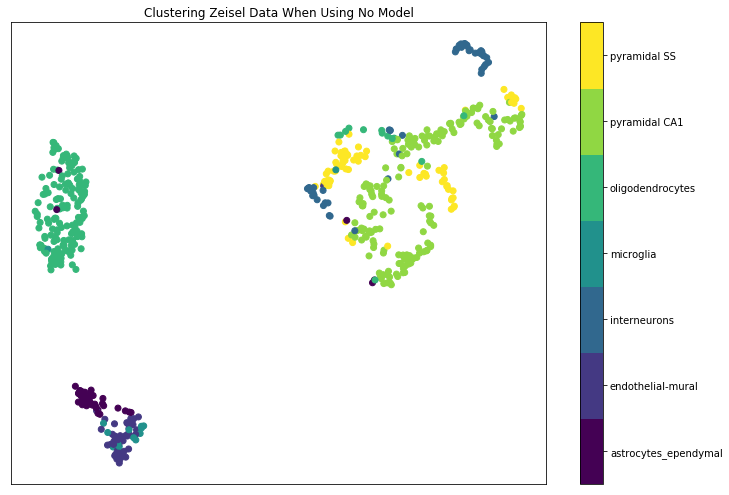

In [33]:
graph_zeisel(test_data.cpu().numpy(), test_labels, "No", zeisel_encoder)

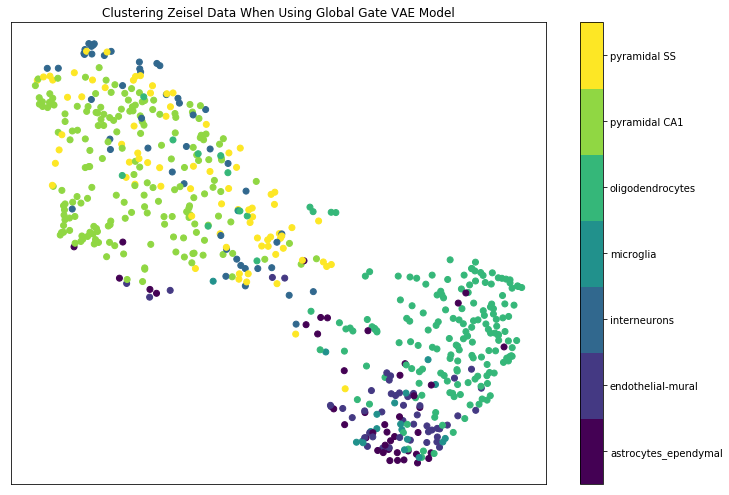

In [34]:
graph_zeisel(test_data[:, inds_global_gate].cpu().numpy(), test_labels, "Global Gate VAE", zeisel_encoder)

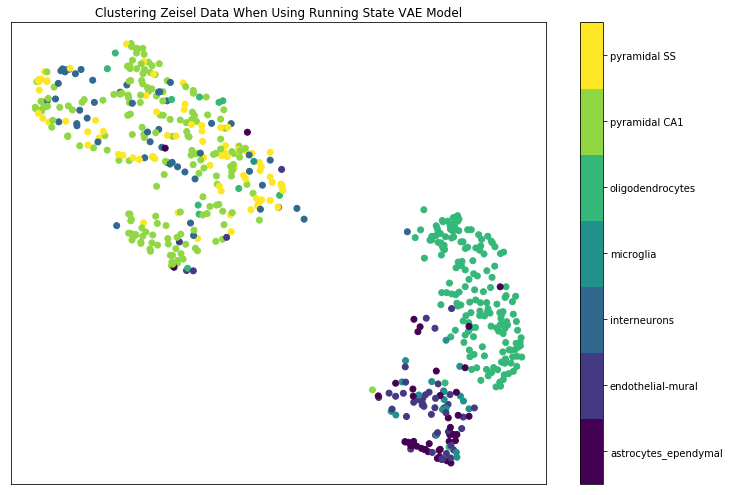

In [35]:
graph_zeisel(test_data[:, inds_running_state].cpu().numpy(), test_labels, "Running State VAE", zeisel_encoder)

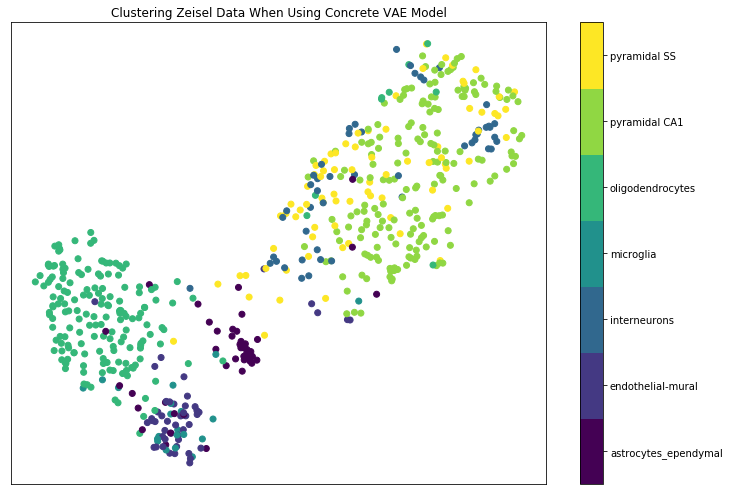

In [36]:
graph_zeisel(test_data[:, inds_concrete_vae].cpu().numpy(), test_labels, "Concrete VAE", zeisel_encoder)